Framework: 

Comparing Commodities & Synthetic Commodities (Stocks/Indices) During Financial Crises
This framework combines physical commodities (gold, oil, wheat) with synthetic commodities (stocks, ETFs, country indices) to identify the best investment during a crisis.
Time 

In [16]:
#impoerts 
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import leaguedashteamstats, leaguedashplayerstats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time as time 
from nba_api.stats.endpoints import commonallplayers, playergamelog
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
# Seasons to collect
seasons = ['2019-20']
all_games = []

# List of valid NBA teams
valid_teams = [
    'ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW',
    'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK',
    'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'
]

for season in seasons:
    print(f"\n📅 Fetching season: {season}")

    # Get all NBA players for this season (active or previously active)
    players = commonallplayers.CommonAllPlayers(is_only_current_season=0, season=season)
    player_df = players.get_data_frames()[0]

    # Filter: only NBA and real team affiliations
    nba_players = player_df[
        (player_df['TEAM_ABBREVIATION'].isin(valid_teams))
    ]

    for _, player in nba_players.iterrows():
        player_id = player['PERSON_ID']
        player_name = player['DISPLAY_FIRST_LAST']
        try:
            gamelog = playergamelog.PlayerGameLog(player_id=player_id, season=season)
            df = gamelog.get_data_frames()[0]
            df['PLAYER_NAME'] = player_name
            df['SEASON'] = season
            all_games.append(df)
            print(f"✔ Retrieved: {player_name} ({season})")
            time.sleep(1)  # Respect API rate limits
        except Exception as e:
            print(f"❌ Failed: {player_name} ({season}) — {e}")

# Combine and save
game_logs_df = pd.concat(all_games, ignore_index=True)
game_logs_df.to_csv("nba_player_game_logs_2019_2024.csv", index=False)
print("\n✅ All data saved to nba_player_game_logs_2019_2024.csv")



📅 Fetching season: 2019-20
✔ Retrieved: Jaylen Adams (2019-20)
✔ Retrieved: Steven Adams (2019-20)
✔ Retrieved: Bam Adebayo (2019-20)
✔ Retrieved: LaMarcus Aldridge (2019-20)
✔ Retrieved: Kyle Alexander (2019-20)
✔ Retrieved: Nickeil Alexander-Walker (2019-20)
✔ Retrieved: Grayson Allen (2019-20)
✔ Retrieved: Jarrett Allen (2019-20)
✔ Retrieved: Al-Farouq Aminu (2019-20)
✔ Retrieved: Justin Anderson (2019-20)
✔ Retrieved: Kyle Anderson (2019-20)
✔ Retrieved: Giannis Antetokounmpo (2019-20)
✔ Retrieved: Kostas Antetokounmpo (2019-20)
✔ Retrieved: Thanasis Antetokounmpo (2019-20)
✔ Retrieved: Carmelo Anthony (2019-20)
✔ Retrieved: OG Anunoby (2019-20)
✔ Retrieved: Ryan Arcidiacono (2019-20)
✔ Retrieved: Trevor Ariza (2019-20)
✔ Retrieved: D.J. Augustin (2019-20)
✔ Retrieved: Deandre Ayton (2019-20)
✔ Retrieved: Dwayne Bacon (2019-20)
✔ Retrieved: Marvin Bagley III (2019-20)
✔ Retrieved: Lonzo Ball (2019-20)
✔ Retrieved: Mo Bamba (2019-20)
✔ Retrieved: J.J. Barea (2019-20)
✔ Retrieved: H

C:\Users\phili\AppData\Local\Temp\ipykernel_39420\3674200404.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game_logs_df = pd.concat(all_games, ignore_index=True)


In [4]:
print("\n🧼 Cleaning combined data...")
csv_path = "nba_player_game_logs_2019_2024.csv"
game_logs_df = pd.read_csv(csv_path)
print(f"🔍 Rows before cleaning: {len(game_logs_df)}")
# Drop games where player didn't actually play
game_logs_df = game_logs_df.dropna(subset=['MIN', 'WL'])

# Fill shot-related columns with 0 if missing (common for 0 attempts)
fill_zero_cols = ['FG3A', 'FG3M', 'FGA', 'FGM', 'FTA', 'FTM']
game_logs_df[fill_zero_cols] = game_logs_df[fill_zero_cols].fillna(0)

# Handle missing PTS, AST, etc. with 0
stat_cols = ['PTS', 'AST', 'REB', 'STL', 'BLK', 'TOV', 'PLUS_MINUS']
game_logs_df[stat_cols] = game_logs_df[stat_cols].fillna(0)



print("✅ Cleaning complete. Sample data:")
print(game_logs_df.head())
print(f"🧼 Rows after cleaning: {len(game_logs_df)}")


🧼 Cleaning combined data...
🔍 Rows before cleaning: 22066
✅ Cleaning complete. Sample data:
   SEASON_ID  Player_ID   Game_ID     GAME_DATE      MATCHUP WL  MIN  FGM  \
0      22019     203500  21901317  Aug 14, 2020    OKC @ LAC  L    6    0   
1      22019     203500  21901306  Aug 12, 2020  OKC vs. MIA  W   20    4   
2      22019     203500  21901265  Aug 05, 2020    OKC @ LAL  W   28    7   
3      22019     203500  21901251  Aug 03, 2020  OKC vs. DEN  L   34    3   
4      22019     203500  21901240  Aug 01, 2020  OKC vs. UTA  W   28    7   

   FGA  FG_PCT  ...  AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  VIDEO_AVAILABLE  \
0    2   0.000  ...    0    0    0    1   0    0           2                1   
1    7   0.571  ...    0    1    0    0   0    8          -7                1   
2   10   0.700  ...    2    0    0    1   2   18          13                1   
3    6   0.500  ...    1    0    0    2   6    9         -18                1   
4   10   0.700  ...    2    0    2    4

## 📊 NBA Player Game Log – Column Descriptions

| Column           | Description |
|------------------|-------------|
| `SEASON_ID`      | Unique identifier for the NBA season (e.g., 22019 for 2019-20). |
| `Player_ID`      | NBA-assigned unique identifier for the player. |
| `Game_ID`        | Unique identifier for the game. |
| `GAME_DATE`      | Date the game was played. |
| `MATCHUP`        | String showing team vs. opponent (e.g., "LAL vs. BOS" or "LAL @ BOS"). |
| `WL`             | Win or Loss for the player's team in that game. |
| `MIN`            | Minutes the player played in the game. |
| `FGM`            | Field Goals Made (total 2s and 3s). |
| `FGA`            | Field Goals Attempted. |
| `FG_PCT`         | Field Goal Percentage = FGM / FGA. |
| `FG3M`           | 3-Point Field Goals Made. |
| `FG3A`           | 3-Point Field Goals Attempted. |
| `FG3_PCT`        | 3-Point Percentage = FG_


### 🧹 Dropping Unnecessary Metadata Columns

To focus our analysis on performance-related statistics, we dropped the following columns:

| Column          | Reason for Removal |
|------------------|--------------------|
| `SEASON_ID`      | Internal season identifier; redundant with `SEASON` and not human-readable. |
| `GAME_ID`        | Unique game identifier; not needed for player-level aggregation. |
| `GAME_DATE`      | Specific date adds no value for performance metrics or PCI calculations. |
| `VIDEO_AVAILABLE`| Indicator for highlight video availability; irrelevant for statistical analysis. |
| `SEASON`         | Season is already filtered and scoped; no need to keep the column in final aggregation. |

Removing these columns reduces dataset size and eliminates non-analytical variables, allowing the model to focus solely on meaningful basketball performance data.


In [5]:
# Step 1: Standardize column names
game_logs_df.columns = game_logs_df.columns.str.strip().str.upper()
print(game_logs_df.columns.tolist())

# Step 2: Create HOME_GAME from MATCHUP


game_logs_df['HOME_GAME'] = game_logs_df['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)
#add team name to team column
game_logs_df['TEAM'] = game_logs_df['MATCHUP'].apply(lambda x: x.split(' ')[0])
#remove vs. from matchup column
game_logs_df['MATCHUP'] = game_logs_df['MATCHUP'].str.replace('vs.', '').str.strip()
game_logs_df = game_logs_df.drop(columns=['MATCHUP'])


# Step 3: Drop other metadata columns
columns_to_drop = ['SEASON_ID', 'GAME_ID', 'GAME_DATE', 'VIDEO_AVAILABLE', 'SEASON']
existing_cols = [col for col in columns_to_drop if col in game_logs_df.columns]
game_logs_df = game_logs_df.drop(columns=existing_cols)

print("✅ Cleaned and updated DataFrame. Columns now:")
print(game_logs_df.columns.tolist())
game_logs_df.to_csv("cleaned data .csv", index=False)
game_logs_df['TS_PCT'] = game_logs_df['PTS'] / (2 * (game_logs_df['FGA'] + 0.44 * game_logs_df['FTA']).replace(0, pd.NA))
game_logs_df['TS_PCT'] = game_logs_df['TS_PCT'].fillna(0)

['SEASON_ID', 'PLAYER_ID', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'PLAYER_NAME', 'SEASON']
✅ Cleaned and updated DataFrame. Columns now:
['PLAYER_ID', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'PLAYER_NAME', 'HOME_GAME', 'TEAM']


C:\Users\phili\AppData\Local\Temp\ipykernel_6744\3368202907.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_logs_df['TS_PCT'] = game_logs_df['TS_PCT'].fillna(0)


### 🔍 Variable Selection & Multivariate Analysis Plan

#### 🧠 Why These Variables Were Chosen

To evaluate player impact on winning (for building the Player Contribution Index), the following variables were selected based on basketball logic and data availability:

| Variable     | Why It Matters |
|--------------|----------------|
| `PTS`        | Direct scoring output — critical for team success. |
| `AST`        | Assists reflect playmaking and team ball movement. |
| `REB`        | Controls possession, prevents second-chance points. |
| `STL`        | Defensive disruptor; often leads to transition points. |
| `BLK`        | Protects the rim and alters opponent scoring. |
| `TOV`        | Negative stat — turnovers reduce scoring chances. |
| `PLUS_MINUS` | Captures overall team success when the player is on the floor. |
| `MIN`        | Proxies importance — more minutes often = more trust/impact. |
| `FG_PCT`, `FG3_PCT`, `FT_PCT` | Measure scoring efficiency — better shot selection and finishing help win games. |

These stats were also chosen because they are:
- Quantifiable across all players and games
- Available in every game log
- Correlated (but not redundant) with team success

---

#### 📊 Multivariate Analysis Methods

To assess which variables contribute most to winning, and how they relate to each other:

1. **Correlation Matrix**
   - To see linear relationships between stats and `WIN`
   - Helps identify multicollinearity and redundancy

2. **Heatmap of Feature Correlation with Wins**
   - Quickly visualizes which stats most positively or negatively influence game outcomes

3. **Scatter Plots**
   - Examples: `PTS` vs `PLUS_MINUS`, `AST` vs `WIN`
   - Explore non-linear or clustered relationships

4. **Logistic Regression**
   - Predicts `WIN` (binary) from player stats
   - Helps estimate strength and direction of each stat's influence



6. **Boxplots by WIN vs LOSS**
   - Compare distributions of key stats in wins vs losses
   - Shows which stats consistently improve in wins

---

#### ✅ Outcome of This Analysis

- Identify which stats most directly influence team wins
- Use this insight to assign weights in the Player Contribution Index (PCI)
- Ensure selected variables are meaningful, non-redundant, and interpretable



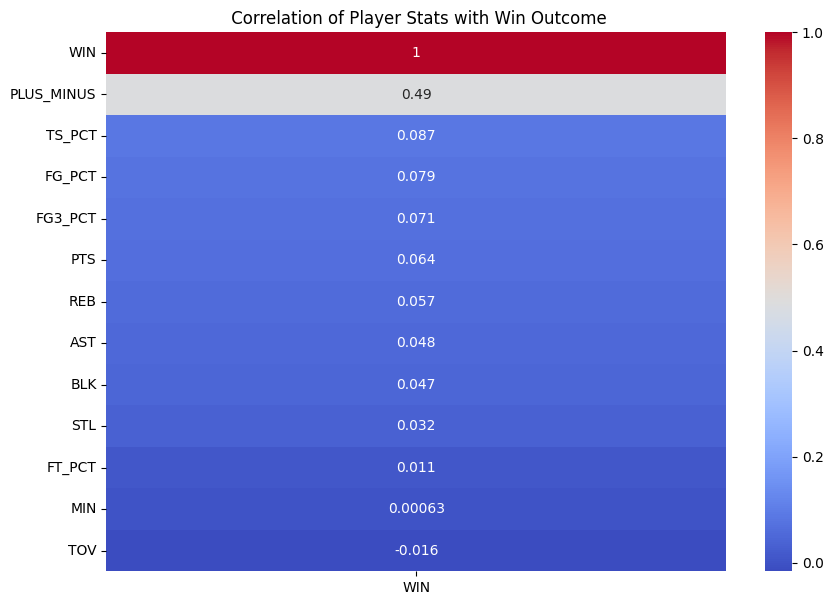

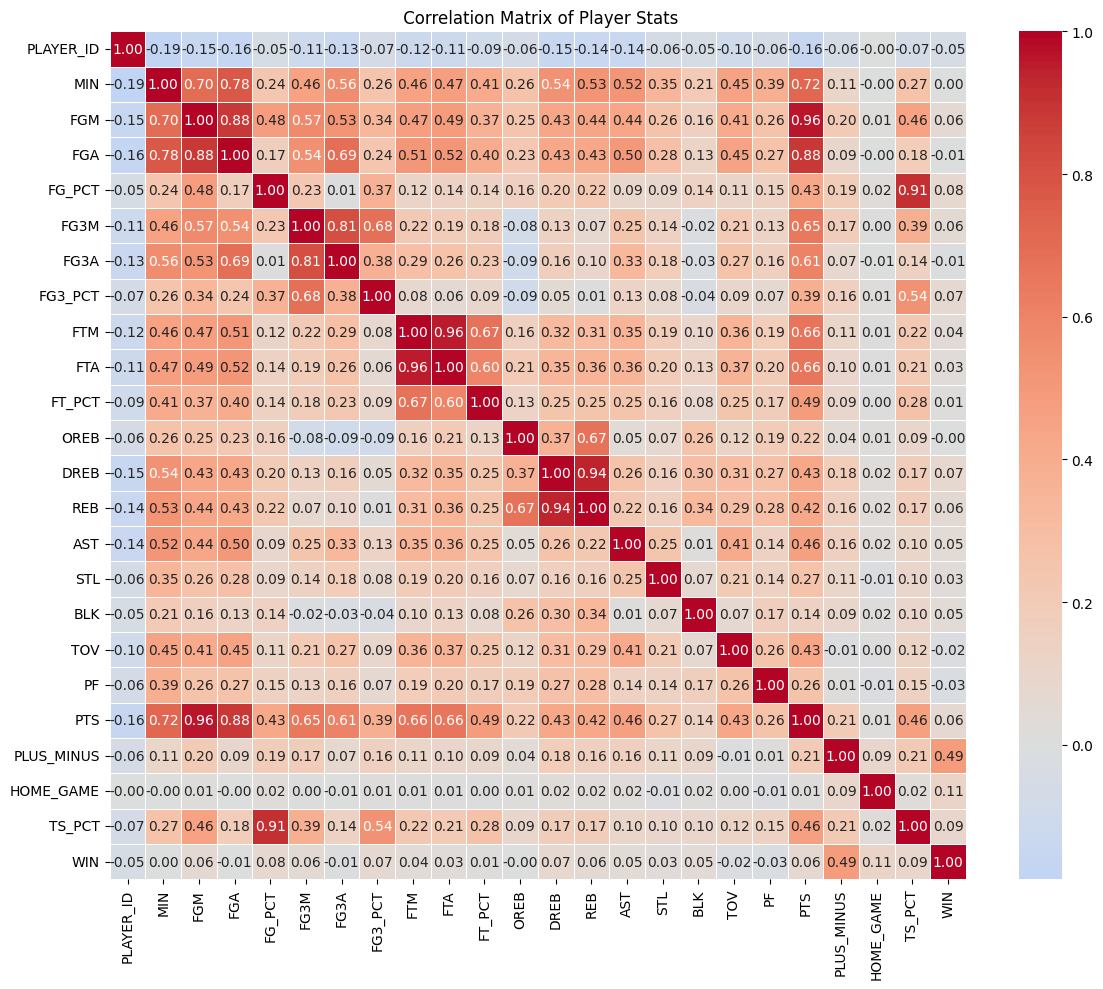

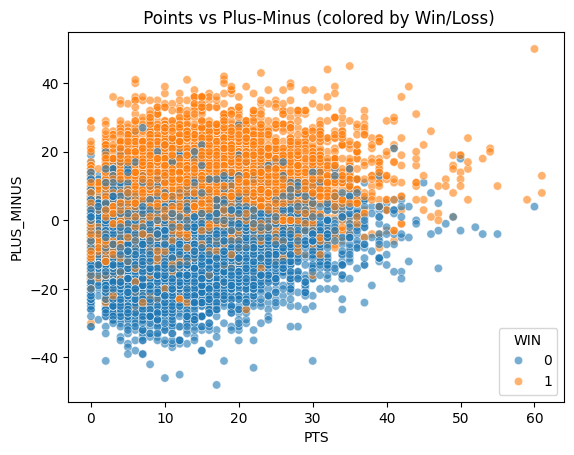

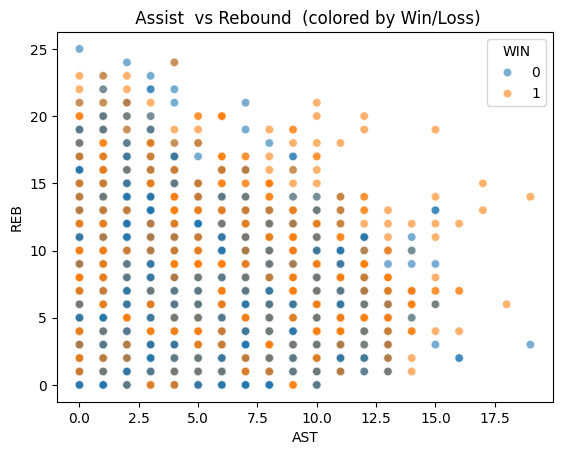

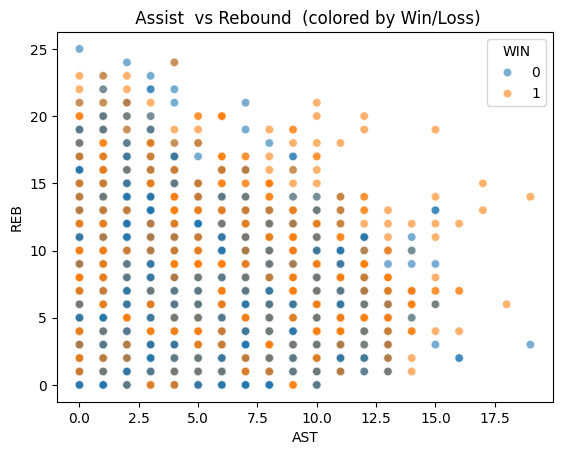

 Logistic Regression Coefficients:
 TS_PCT        0.135921
PLUS_MINUS    0.121667
BLK           0.037892
TOV           0.030076
FG3_PCT       0.017740
REB           0.004249
PTS           0.004034
STL          -0.004856
AST          -0.011264
MIN          -0.015524
FT_PCT       -0.137441
FG_PCT       -0.273579
dtype: float64


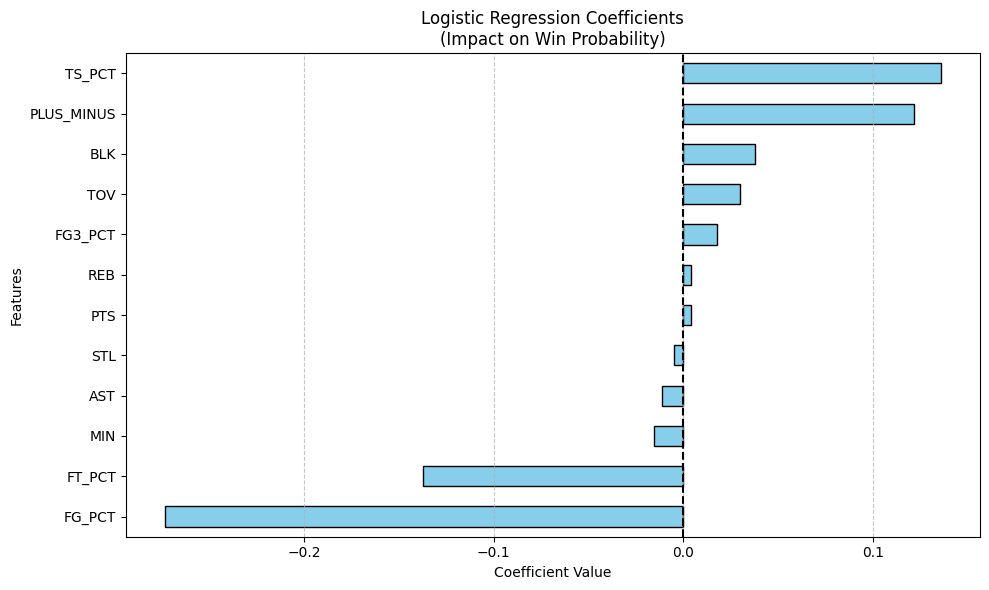

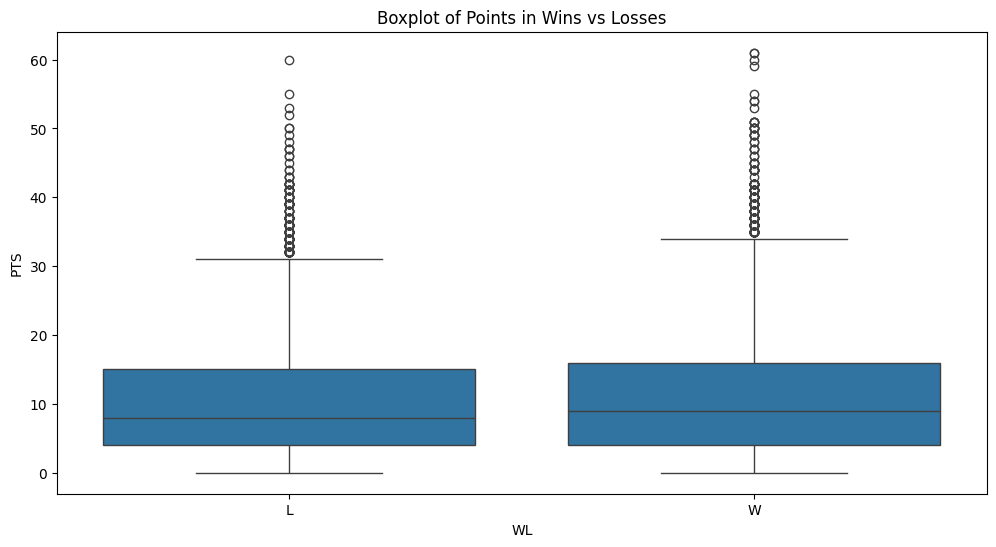

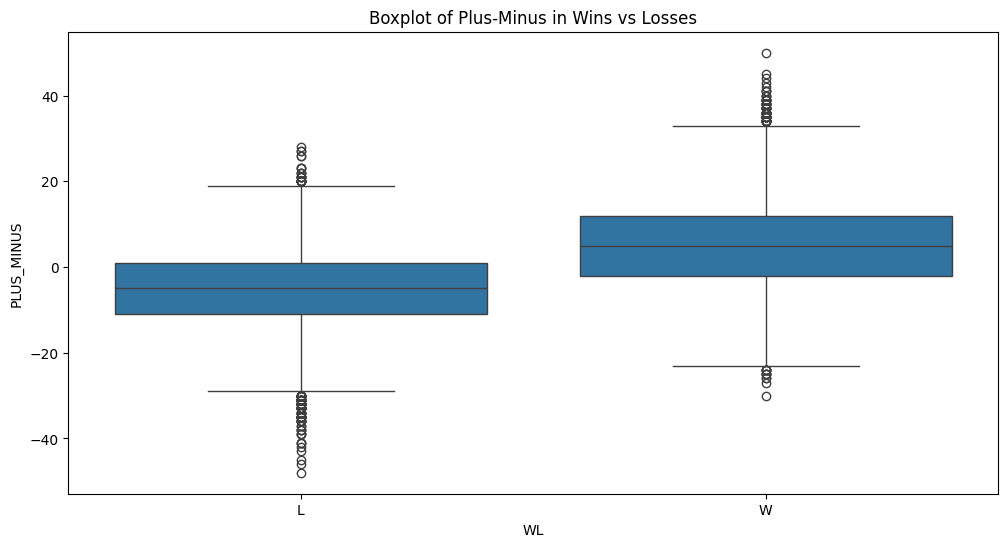

In [6]:
game_logs_df['WIN'] = game_logs_df['WL'].apply(lambda x: 1 if x == 'W' else 0)

# Step 2: Select key features for analysis
features = [
    'PTS', 'AST', 'REB', 'STL', 'BLK', 'TOV',
    'PLUS_MINUS', 'MIN', 'FG_PCT', 'FG3_PCT', 'FT_PCT','TS_PCT',
]

# Step 3: Correlation Matrix (including WIN)
corr = game_logs_df[features + ['WIN']].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr[['WIN']].sort_values(by='WIN', ascending=False), annot=True, cmap='coolwarm')
plt.title(" Correlation of Player Stats with Win Outcome")
plt.show()

numeric_df = game_logs_df.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title(" Correlation Matrix of Player Stats")
plt.tight_layout()
plt.show()

# Step 4: Scatter Plot Example – PTS vs PLUS_MINUS
sns.scatterplot(data=game_logs_df, x='PTS', y='PLUS_MINUS', hue='WIN', alpha=0.6)
plt.title(" Points vs Plus-Minus (colored by Win/Loss)")
plt.show()

sns.scatterplot(data=game_logs_df, x='AST', y='REB', hue='WIN', alpha=0.6)
plt.title(" Assist  vs Rebound  (colored by Win/Loss)")
plt.show()

sns.scatterplot(data=game_logs_df, x='AST', y='REB', hue='WIN', alpha=0.6)
plt.title(" Assist  vs Rebound  (colored by Win/Loss)")
plt.show()

# Step 5: Logistic Regression — Predict WIN from player stats
X = game_logs_df[features].fillna(0)
y = game_logs_df['WIN']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Coefficients = variable influence on probability of win
coeffs = pd.Series(model.coef_[0], index=features).sort_values(ascending=False)
print(" Logistic Regression Coefficients:\n", coeffs)
coeffs = pd.Series(model.coef_[0], index=features).sort_values()

plt.figure(figsize=(10, 6))
coeffs.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Logistic Regression Coefficients\n(Impact on Win Probability)")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.axvline(0, color='black', linestyle='--')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 6: Boxplots of key features in wins vs losses
plt.figure(figsize=(12, 6))
sns.boxplot(data=game_logs_df, x='WL', y='PTS')
plt.title("Boxplot of Points in Wins vs Losses")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=game_logs_df, x='WL', y='PLUS_MINUS')
plt.title("Boxplot of Plus-Minus in Wins vs Losses")
plt.show()  

## 🧩 Selecting & Grouping Variables for Sub-Indices

Looking at your full correlation matrix, we can see clear **clusters** of highly related stats. To avoid redundancy and to build meaningful sub-indices, we’ll group variables into these themes:

| Sub-Index              | Candidate Variables                            | Rationale                                                                                           |
|------------------------|------------------------------------------------|-----------------------------------------------------------------------------------------------------|
| **Scoring Volume**     | `PTS`                                          | Core measure of scoring output. Highly correlated with FGM/FGA but more intuitive.                  |
| **Shooting Efficiency**| `TS_PCT`, `FG_PCT`, `FT_PCT`                   | True Shooting % (`TS_PCT`) already subsumes FG_PCT & FT_PCT. Keeps efficiency focus, reduces multicollinearity. |
| **Playmaking**         | `AST`, `AST_TO_ratio`                          | Assists drive offense. Include AST/TO ratio to account for ball security (`AST_TO_ratio` = AST / TOV). |
| **Rebounding**         | `REB`                                          | Total rebounds combine OREB & DREB (which are themselves 0.94 correlated). Keeps one clean metric.  |
| **Defense & Disruption**| `STL`, `BLK`                                  | Steals and blocks reflect defensive impact.                                                        |
| **Ball Control**       | `TOV`, `PF`                                    | Turnovers hurt offense; personal fouls contribute to defensive aggressiveness/risk.                  |
| **Overall Impact**     | `PLUS_MINUS`, `WIN`                            | Captures net team success while player is on court and actual game outcomes.                        |
| **Usage & Opportunity**| `MIN`, `HOME_GAME`                             | Minutes reflect opportunity; HOME_GAME controls for home/away splits.                                |

### 🚀 Next Steps

1. **Compute Sub-Indices** by normalizing and averaging the variables in each group.  
2. **Weight & Aggregate** these sub-indices into your final PCI.  
3. **Validate** by ensuring each sub-index adds unique information (low inter–sub-index correlation).  
4. **Visualize** each sub-index distribution and the final PCI ranking.

This grouping balances **coverage** (all facets of play) with **parsimony** (avoiding redundant metrics).```



In [10]:
from sklearn.preprocessing import StandardScaler


game_logs_df['AST_TO_ratio'] = game_logs_df['AST'] / game_logs_df['TOV'].replace(0, np.nan)
game_logs_df['AST_TO_ratio'] = game_logs_df['AST_TO_ratio'].fillna(game_logs_df['AST'])

# 2. Select all features that go into sub‐indices
features_to_scale = [
    'PTS','TS_PCT','AST','AST_TO_ratio','REB',
    'STL','BLK','TOV','PF','PLUS_MINUS','WIN',
    'MIN','HOME_GAME'
]

# 3. Standardize them
scaler = StandardScaler()
scaled_vals = scaler.fit_transform(game_logs_df[features_to_scale])
scaled = pd.DataFrame(scaled_vals, columns=features_to_scale, index=game_logs_df.index)

# 4. Compute each sub‐index as the mean of its group
scaled['scoring_volume_index']     = scaled['PTS']
scaled['shooting_efficiency_index']= scaled['TS_PCT']
scaled['playmaking_index']         = scaled[['AST','AST_TO_ratio']].mean(axis=1)
scaled['rebounding_index']         = scaled['REB']
scaled['defense_index']            = scaled[['STL','BLK']].mean(axis=1)
scaled['ball_control_index']       = scaled[['TOV','PF']].mean(axis=1)
scaled['overall_impact_index']     = scaled[['PLUS_MINUS','WIN']].mean(axis=1)
scaled['usage_opportunity_index']  = scaled[['MIN','HOME_GAME']].mean(axis=1)

# 5. Combine sub‐indices back with player names
subindices = game_logs_df[['PLAYER_NAME','TEAM','WIN']].join(scaled[[
    'scoring_volume_index','shooting_efficiency_index','playmaking_index',
    'rebounding_index','defense_index','ball_control_index',
    'overall_impact_index','usage_opportunity_index',
]],).reset_index(drop=True)
#CHECK IF TEAM NAME IS IN THE DATAFRAME
print(subindices['TEAM'].unique())

subindices.to_csv("nba_player_subindices.csv", index=False)
# calculat the team average of each subindex

team_col = [col for col in subindices.columns if 'TEAM' in col.upper() and subindices[col].dtype == object]
if not team_col:
    raise ValueError("No team column found in subindices")
team_col = team_col[0]

# Identify numeric sub-index columns
numeric_cols = subindices.select_dtypes(include=[np.number]).columns.tolist()

# Compute team‐average of sub-indices
team_averages = (
    subindices
    .groupby(team_col)[numeric_cols]
    .mean()
    .reset_index()
)
#save team averages to csv
team_averages.to_csv("nba_team_averages.csv", index=False)
# Calculate player averages
player_avg_df = subindices.groupby(['PLAYER_NAME', 'TEAM'], as_index=False).mean(numeric_only=True)
# SAVE PLAYER AVERAGES TO CSV
player_avg_df.to_csv("nba_player_averages.csv", index=False)

print(subindices.head())




['OKC' 'MIA' 'SAS' 'NOP' 'MEM' 'BKN' 'ORL' 'MIL' 'LAL' 'POR' 'TOR' 'CHI'
 'SAC' 'PHX' 'CHA' 'DAL' 'NYK' 'DEN' 'MIN' 'WAS' 'ATL' 'LAC' 'IND' 'UTA'
 'DET' 'GSW' 'BOS' 'PHI' 'HOU' 'CLE']
    PLAYER_NAME TEAM  WIN  scoring_volume_index  shooting_efficiency_index  \
0  Steven Adams  OKC    0             -1.240641                  -1.953128   
1  Steven Adams  OKC    1             -0.309707                  -0.073361   
2  Steven Adams  OKC    1              0.853961                   0.594905   
3  Steven Adams  OKC    0             -0.193340                   0.194312   
4  Steven Adams  OKC    1              0.621228                   0.475161   

   playmaking_index  rebounding_index  defense_index  ball_control_index  \
0         -0.904196         -0.079807      -0.656942           -0.775068   
1         -0.904196          1.067059      -0.135885           -1.126438   
2          0.071788          0.780342      -0.656942           -0.105522   
3         -0.561133          1.640491      

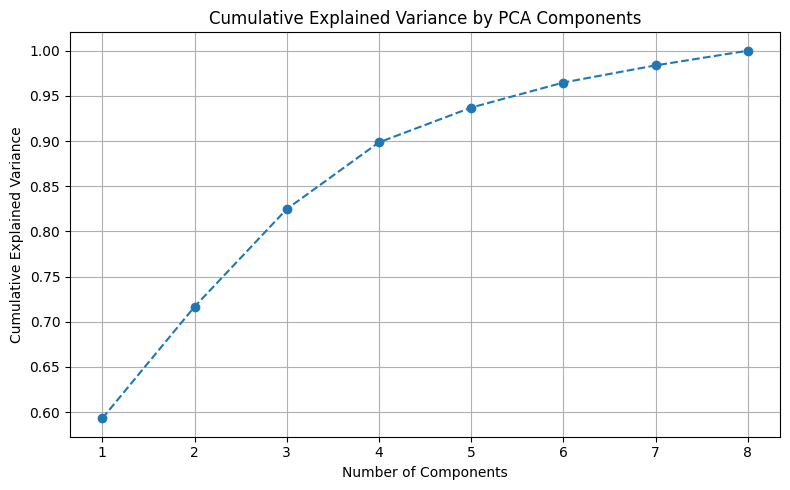

KeyError: 'Cluster'

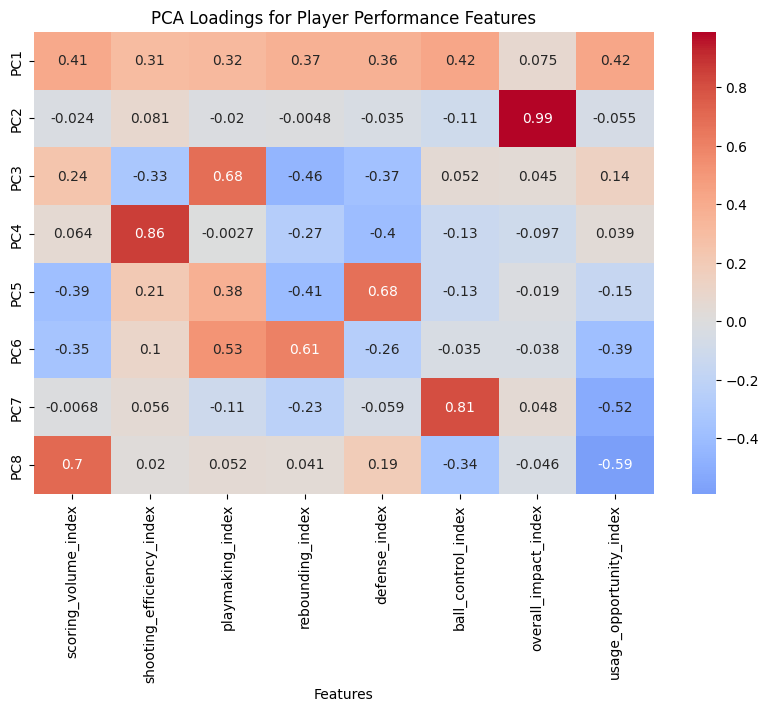

<Figure size 1000x700 with 0 Axes>

In [ ]:
# Define the performance features
features = [
    'scoring_volume_index', 'shooting_efficiency_index', 'playmaking_index',
    'rebounding_index', 'defense_index', 'ball_control_index',
    'overall_impact_index', 'usage_opportunity_index'
]

# Extract the feature matrix
X = player_avg_df[features]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

# Create a new DataFrame for visualization
pca_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
pca_df['PLAYER_NAME'] = player_avg_df['PLAYER_NAME']
pca_df['TEAM'] = player_avg_df['TEAM']

# Plot
pca_full = PCA(n_components=8)
pca_full.fit(X_scaled)

# Step 5: Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, 9), pca_full.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()

loadings_df = pd.DataFrame(
    pca_full.components_,
    columns=features,
    index=[f'PC{i+1}' for i in range(len(features))]
)
# Step 6: Plot PCA loadings
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Loadings for Player Performance Features')
plt.xlabel('Features')

# Step 4: Visualize PCA with clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='tab10', alpha=0.6)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA and KMeans Clustering: NBA Player Performance")
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()

## Evaluation of Clustering Methods (DBSCAN and KMeans)

### Why Clustering Was Considered

As part of the CA1 specification, clustering was explored as a potential method to uncover groups or "archetypes" of NBA players based on performance metrics. Two common clustering methods were evaluated:
- **KMeans**: partitions data into a pre-defined number of clusters
- **DBSCAN**: density-based clustering that finds groups of closely packed points and identifies outliers

---

### Why DBSCAN Was Not Suitable

**DBSCAN** is highly effective when:
- The data has **uneven density** (some groups are tight, others are spread out)
- You want to identify **outliers** or noise
- The number of clusters is **not known in advance**

However, in this dataset:
- The data is **well-distributed and normalized**, without varying density regions
- PCA-reduced data shows a mostly **uniform structure** without clear dense/sparse areas
- There are **no significant outliers** to detect

> **Conclusion**: DBSCAN failed to discover meaningful clusters and misclassified many legitimate data points as noise, making it unsuitable.

---

### Why KMeans Was Also Not Effective

KMeans assumes:
- Data forms **spherical clusters**
- Each cluster is of similar **size and density**
- There is a **clear “center”** to each group

In our analysis:
- The PCA scatterplot showed a **continuous distribution** rather than distinct groups
- Clustering results were **arbitrary**, sensitive to the number of clusters chosen (k), and **lacked interpretability**
- The objective of the project was to create a **composite index**, not to find player groupings

> **Conclusion**: KMeans added no meaningful insight. The data is better interpreted as a continuum of player performance rather than discrete clusters.

---

### Final Decision

After exploratory analysis, it was determined that clustering — while a valuable technique in some contexts — does not provide additional value in this case. The dataset lends itself better to **dimensionality reduction (PCA)** and **composite scoring**, as the goal is to **rank players**, not group them.

As a result, further analysis focused on:
- **Principal Component Analysis** for dimensionality reduction
- **Weighted aggregation** to compute a single composite index
- **Visualizations** for interpretation and comparison

## Why PCA Was Not Suitable for Composite Index Construction

### Overview
Principal Component Analysis (PCA) was explored as a potential method to assign weights to sub-indices when building the composite performance index for NBA players. While PCA is a well-regarded technique in multivariate analysis, it was ultimately determined to be ineffective for our project's specific goals.

---

### 1. **PCA Is Unsupervised**
PCA does not take any target variable (like `WIN` or `SUCCESS`) into account. It simply finds the directions (principal components) that maximize variance in the data — **not what makes a player "good"** or more successful.

As a result, the components are not aligned with basketball performance outcomes or expert understanding of the game.

---

### 2. **PCA Weights Are Driven by Variance, Not Value**
The loadings derived from PCA represent features that vary the most between players. However, features with high variance are not necessarily the most important for performance.

For example, a feature like `ball_control_index` might receive high PCA weight because it has large spread — not because it's critical to winning or player efficiency.

---

### 3. **Lack of Interpretability**
PCA creates abstract components that are linear combinations of sub-indices. While mathematically optimal, these components:
- Lack intuitive interpretation
- Are difficult to explain to a non-technical audience
- Provide no clear justification for performance weighting

---

### 4. **No Meaningful Improvement in Results**
When used for clustering or composite index creation:
- PCA-derived weights did not produce rankings significantly different from equal or expert-based weights
- The clusters based on PCA were difficult to interpret and added no practical value

---

### 5. **Better Alternatives Available**
For performance-based weighting, **regression against a target** (like `WIN`) or **expert-informed weights** are more aligned with the project’s goals. These methods provide:
- Supervised, outcome-driven insights
- Transparent, explainable weight distributions
- Direct relevance to real-world player success

---

### Conclusion
While PCA was useful for initial data exploration and dimensionality reduction, it was **not a suitable foundation** for weighting or constructing the final composite index. More targeted, interpretable, and goal-aligned methods were favored instead.

In [25]:
weights = {
    'scoring_volume_index': 0.20,
    'shooting_efficiency_index': 0.15,
    'playmaking_index': 0.15,
    'rebounding_index': 0.10,
    'defense_index': 0.10,
    'ball_control_index': 0.10,
    'overall_impact_index': 0.10,
    'usage_opportunity_index': 0.10
}


player_avg_df['composite_index'] = sum(
    player_avg_df[feature] * weight for feature, weight in weights.items()
)

top_composite_df = player_avg_df[['PLAYER_NAME', 'composite_index']].sort_values(by='composite_index', ascending=False).head(20)

print("\nTop 20 Players in the 2019-2020 season  by Composite Index:")
print(top_composite_df)



Top 20 Players in the 2019-2020 season  by Composite Index:
               PLAYER_NAME  composite_index
227           James Harden         1.198210
184  Giannis Antetokounmpo         1.150629
349            Luka Dončić         1.046092
342           LeBron James         1.019232
461      Russell Westbrook         0.960216
96          Damian Lillard         0.902923
301     Karl-Anthony Towns         0.893002
24           Anthony Davis         0.890297
509             Trae Young         0.862469
302          Kawhi Leonard         0.840720
414           Nikola Jokić         0.829904
335           Kyrie Irving         0.813481
17          Andre Drummond         0.793822
36             Ben Simmons         0.780442
45            Bradley Beal         0.773812
261            Joel Embiid         0.762613
130           Devin Booker         0.756124
140       Domantas Sabonis         0.745959
333             Kyle Lowry         0.735495
298           Jusuf Nurkić         0.730649
